# Logistic Regression 
<p> Implement multiclass logistic regression for MNIST. You should try both PCA and LDA for dimensionality reduction, first. In brief, multiclass logistic regression models the class posteriors of an image log-linearly in terms of its features so that 

$$
P\left(y_{m, n}=1 \mid \mathbf{x}_n\right)=\frac{\exp \left(\boldsymbol{\theta}_m^{\top} \mathbf{x}_n\right)}{\sum_{i=1}^M \exp \left(\boldsymbol{\theta}_i^{\top} \mathbf{x}_n\right)}
$$

i.e. the
softmax function, where ym,n is the indicator of xn being in class ωm. The model
parameters are estimated to minimize the negative log-likelihood of the class labels,
which are encoded as categorical vectors. The negative log-likelihood takes the form
$$
\ell\left(\boldsymbol{\theta}_1, \cdots, \boldsymbol{\theta}_M\right)=-\sum_{n=1}^N \sum_{m=1}^M y_{m, n} \ln \left(\frac{\exp \left(\boldsymbol{\theta}_m^{\top} \mathbf{x}_n\right)}{\sum_{i=1}^M \exp \left(\boldsymbol{\theta}_i^{\top} \mathbf{x}_n\right)}\right)
$$


; this is sometimes called
the cross-entropy loss function.

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
np.random.seed(1024)

>> If Running for the first time Uncomment and run the following cell

In [4]:
## train_load,test_load = load_dataset(False)


In [5]:
# Load Downloaded Data and Normalize
from mlxtend.data import loadlocal_mnist
from sklearn.preprocessing import StandardScaler
import platform

original_train_X, original_train_y = loadlocal_mnist(
    images_path='dataset/MNIST/raw/train-images-idx3-ubyte',
    labels_path='dataset/MNIST/raw/train-labels-idx1-ubyte')

original_test_X, original_test_y = loadlocal_mnist(
    images_path='dataset/MNIST/raw/t10k-images-idx3-ubyte',
    labels_path='dataset/MNIST/raw/t10k-labels-idx1-ubyte')

train_X, train_y = original_train_X, original_train_y

test_X, test_y = original_test_X, original_test_y

# Normalize Data:
sc = StandardScaler()

# First fit then transform
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)
N = train_X.shape[1]
C = len(set(train_y))
assert (C == 10)
train_X.shape, train_y.shape, test_X.shape, test_y.shape


((60000, 784), (60000,), (10000, 784), (10000,))

>> Set hyperparameters to loop and train

In [6]:
from numpy import random
from utils import *


In [7]:
# Predict and calculate metrics
def test(x, y, w, b) -> tuple[float, float]:
    try:
        samples = len(y)
        idx = [np.squeeze(softmax((x[i] @ w.T))) for i in range(samples)]
        idx = np.array(np.array(idx))
        correct = sum(np.argmax(idx, axis=1) == y)/samples
        error = [negative_log_likelihood(idx[i], y[i]) for i in range(samples)]
        return correct, sum(error)
    except Exception as ex:
        print(ex)


In [8]:
def LogisticRegression(train_X, test_X, train_y, test_y, lr=0.0025, batch_size=100, epoch=15):
    H, N = train_X.shape[0], train_X.shape[1]
    # Initialize momentum:
    w = random.randn(C, N) / np.sqrt(C*N)
    b = random.rand(C, 1)/np.sqrt(N)
    epoch_result1 = []
    epoch_result2 = []
    epoch_result3 = []
    epoch_result4 = []
    w_dash = np.zeros(w.shape)
    b_dash = np.zeros(b.shape)
    loss = 0
    accuraccy = []
    for iter in tqdm(range(epoch)):
        shuffle = random.choice(H, H, replace=False)

        # Divide data in batches:
        total_batches = int(H/batch_size)
        train_X_chunks = np.array_split(train_X, total_batches)
        train_y_chunks = np.array_split(train_y, total_batches)
        for batch in range(total_batches):
            x = train_X_chunks[batch]
            y = train_y_chunks[batch]
            # loss = 0

            lst_dw, lst_db = [], []
            for point in range(x.shape[0]):
                x_p = (x[point]).reshape((N, 1))
                y_p = y[point]
                # Predict
                y_hat_ = softmax((w@x_p)+b)
                # Get Loss
                loss += negative_log_likelihood(y_hat_, y_p)
                # Get gradients:
                k = np.zeros((10, 1))
                k[y_p][0] = 1
                lst_dw.append(-1*((k-y_hat_) @ x_p.reshape((1, N))))
                lst_db.append(-1*(k-y_hat_))

            # Momentum:
            w_dash = 0.9*w_dash + lr*(sum(lst_dw)/(x.shape[0]))
            b_dash = 0.9*b_dash+lr*(sum(lst_db)/(x.shape[0]))
            w -= w_dash
            b -= b_dash
            #print('\t\t-- ',iter,' : ',loss,' --')
        train_acc, train_loss = test(train_X, train_y, w, b)
        epoch_result1.append(train_acc)
        epoch_result2.append(train_loss/float(100))

        print('-- Train: ', iter, ': Accuraccy = ', train_acc,
              '\tError: ', train_loss/float(100), ' --')
        test_acc, test_loss = test(test_X, test_y, w, b)
        print('-- Test: ', iter, ': Accuraccy = ', test_acc,
              '\tError: ', test_loss/float(100), ' --')
        epoch_result3.append(test_acc)
        epoch_result4.append(test_loss/float(100))

    # Plot Training Results
    plt.plot(range(epoch), epoch_result1, 'g', label='Training Accuraccy')
    plt.title('Training accuraccy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # Plot Training Results
    plt.plot(range(epoch), epoch_result2, 'r', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Plot Testing Results
    plt.plot(range(epoch), epoch_result3, 'g', label='Testing Accuraccy')
    plt.title('Testing accuraccy ')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # Plot Testing Results
    plt.plot(range(epoch), epoch_result4, 'r', label='Testing loss')
    plt.title('Testing loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return [epoch_result1, epoch_result2, epoch_result3, epoch_result4]


  7%|▋         | 1/15 [00:04<01:00,  4.29s/it]

-- Train:  0 : Accuraccy =  0.8807166666666667 	Error:  268.2633991996311  --
-- Test:  0 : Accuraccy =  0.8848 	Error:  43.547988196162976  --


 13%|█▎        | 2/15 [00:08<00:57,  4.44s/it]

-- Train:  1 : Accuraccy =  0.8956833333333334 	Error:  229.13691327262026  --
-- Test:  1 : Accuraccy =  0.8986 	Error:  37.35315754574651  --


 20%|██        | 3/15 [00:13<00:54,  4.50s/it]

-- Train:  2 : Accuraccy =  0.9018833333333334 	Error:  212.3397253976775  --
-- Test:  2 : Accuraccy =  0.9024 	Error:  34.7762408060336  --


 27%|██▋       | 4/15 [00:18<00:50,  4.57s/it]

-- Train:  3 : Accuraccy =  0.9057833333333334 	Error:  202.43752463408563  --
-- Test:  3 : Accuraccy =  0.9059 	Error:  33.30612253622273  --


 33%|███▎      | 5/15 [00:22<00:45,  4.60s/it]

-- Train:  4 : Accuraccy =  0.9084666666666666 	Error:  195.73140109521992  --
-- Test:  4 : Accuraccy =  0.908 	Error:  32.34287847975802  --


 40%|████      | 6/15 [00:27<00:41,  4.60s/it]

-- Train:  5 : Accuraccy =  0.9106333333333333 	Error:  190.8126332266977  --
-- Test:  5 : Accuraccy =  0.9092 	Error:  31.659575417224758  --


 47%|████▋     | 7/15 [00:31<00:36,  4.59s/it]

-- Train:  6 : Accuraccy =  0.9123166666666667 	Error:  187.0138764383951  --
-- Test:  6 : Accuraccy =  0.9104 	Error:  31.15002171339458  --


 53%|█████▎    | 8/15 [00:36<00:32,  4.60s/it]

-- Train:  7 : Accuraccy =  0.9137666666666666 	Error:  183.9711880376212  --
-- Test:  7 : Accuraccy =  0.9117 	Error:  30.756651717123454  --


 60%|██████    | 9/15 [00:41<00:27,  4.63s/it]

-- Train:  8 : Accuraccy =  0.91495 	Error:  181.46703961355735  --
-- Test:  8 : Accuraccy =  0.9129 	Error:  30.445038450164496  --


 67%|██████▋   | 10/15 [00:45<00:23,  4.62s/it]

-- Train:  9 : Accuraccy =  0.9159166666666667 	Error:  179.36262627473982  --
-- Test:  9 : Accuraccy =  0.9134 	Error:  30.193287263706626  --


 73%|███████▎  | 11/15 [00:50<00:18,  4.64s/it]

-- Train:  10 : Accuraccy =  0.9167166666666666 	Error:  177.56464730074106  --
-- Test:  10 : Accuraccy =  0.9146 	Error:  29.986762832563592  --


 80%|████████  | 12/15 [00:55<00:13,  4.66s/it]

-- Train:  11 : Accuraccy =  0.9171333333333334 	Error:  176.00768268525934  --
-- Test:  11 : Accuraccy =  0.9154 	Error:  29.81527880131742  --


 87%|████████▋ | 13/15 [00:59<00:09,  4.69s/it]

-- Train:  12 : Accuraccy =  0.91765 	Error:  174.64422443888193  --
-- Test:  12 : Accuraccy =  0.9157 	Error:  29.67151025165049  --


 93%|█████████▎| 14/15 [01:04<00:04,  4.69s/it]

-- Train:  13 : Accuraccy =  0.9184166666666667 	Error:  173.4387931374934  --
-- Test:  13 : Accuraccy =  0.9163 	Error:  29.55004042458934  --


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]

-- Train:  14 : Accuraccy =  0.919 	Error:  172.36434395519998  --
-- Test:  14 : Accuraccy =  0.916 	Error:  29.446774373369603  --


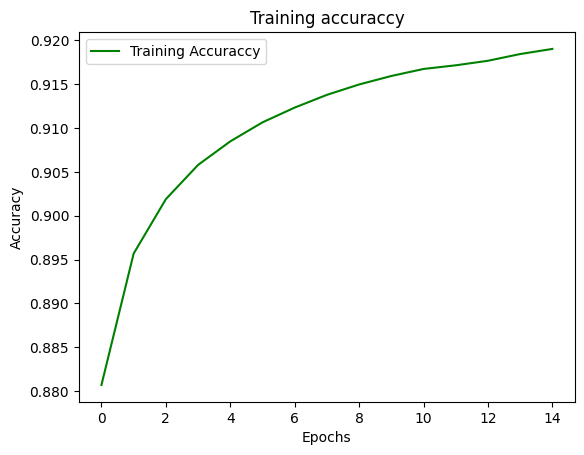

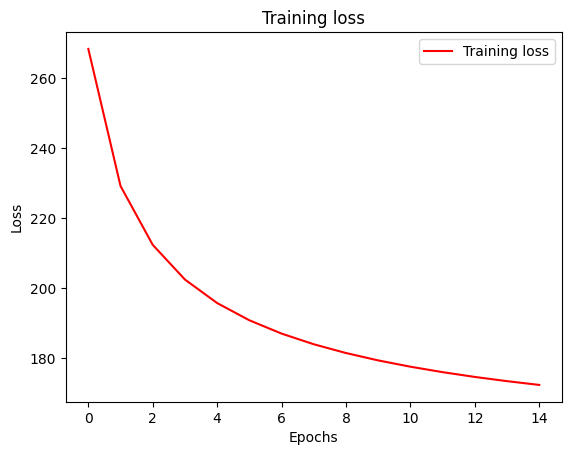

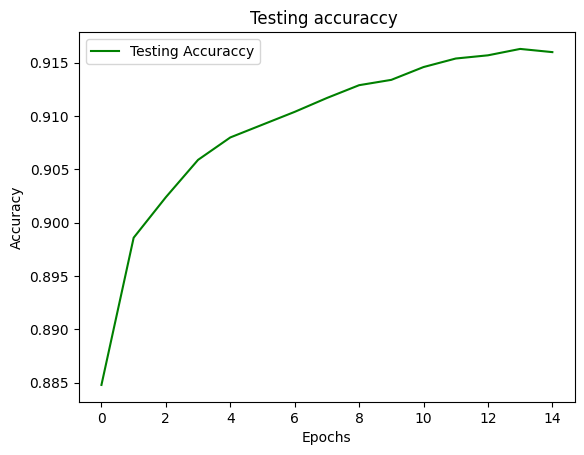

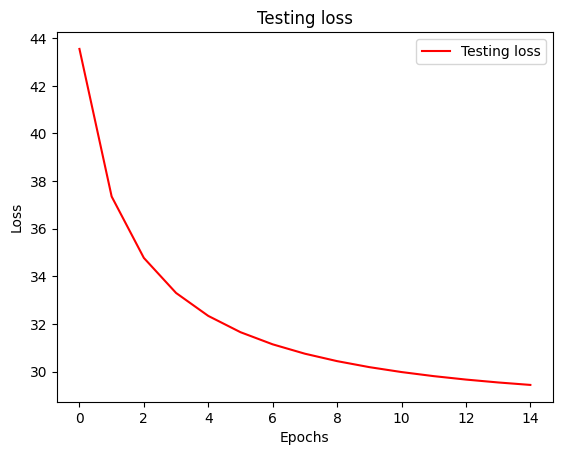

In [9]:
result = LogisticRegression(
    train_X, test_X, train_y, test_y, lr=0.0025, batch_size=500, epoch=15)


In [20]:
best_train_acc = result[0]
best_test_acc = result[2]

best_train_acc = best_train_acc[np.argmax(best_train_acc)]
best_test_acc = best_test_acc[np.argmax(best_test_acc)]

best_train_acc, best_test_acc


(0.9237666666666666, 0.9168)

In [ ]:
# hyper_param = {
#     "lr": [0.0025, 0.005],
#     "epochs": [15, 100],
#     "batch": [100, 10],
#     "learning_decay": [0, 1],
#     "decay_factor": [0.75, 0.5],
#     "momentum": [0, 1],
#     "mu": [0.9, 0.9]
# }


In [12]:
best_train_acc = result[0]
best_test_acc = result[2]

best_train_acc = best_train_acc[np.argmax(best_train_acc)]
best_test_acc = best_test_acc[np.argmax(best_test_acc)]

print('Best training accuracy achieved at epoch : ', np.argmax(result[0]))
print('Best test accuracy achieved at epoch : ', np.argmax(result[2]))
best_train_acc, best_test_acc


Best training accuracy achieved at epoch :  6
Best test accuracy achieved at epoch :  8


(0.9237666666666666, 0.9168)

# PCA

In [ ]:
seq = np.random.randint(0,60000,20000)
train_sampled_X = original_train_X[seq]
train_sampled_y = original_train_y[seq]
test_y = original_test_y
train_y = train_sampled_y

# Normalize Data:
sc = StandardScaler()

# First fit then transform
train_sampled_X = sc.fit_transform(train_sampled_X)
original_test_X = sc.transform(original_test_X)

train_X,test_X = dim_reduction('pca','rbf',train_sampled_X,original_test_X,train_sampled_y)


  0%|          | 0/15 [00:00<?, ?it/s]

-- Train:  0 : Accuraccy =  0.8812666666666666 	Error:  268.1854235196071  --
-- Test:  0 : Accuraccy =  0.8844 	Error:  43.585054822061636  --


  7%|▋         | 1/15 [01:07<15:43, 67.36s/it]

-- Train:  1 : Accuraccy =  0.8953666666666666 	Error:  229.16670692571725  --
-- Test:  1 : Accuraccy =  0.8971 	Error:  37.43378082113133  --


 13%|█▎        | 2/15 [01:14<06:53, 31.83s/it]

-- Train:  2 : Accuraccy =  0.9011666666666667 	Error:  212.33539306458636  --
-- Test:  2 : Accuraccy =  0.9026 	Error:  34.86078911605552  --


 20%|██        | 3/15 [01:20<04:03, 20.27s/it]

-- Train:  3 : Accuraccy =  0.9051833333333333 	Error:  202.39744192493293  --
-- Test:  3 : Accuraccy =  0.9061 	Error:  33.38885165774594  --


 27%|██▋       | 4/15 [01:27<02:43, 14.82s/it]

-- Train:  4 : Accuraccy =  0.9081333333333333 	Error:  195.66138077902397  --
-- Test:  4 : Accuraccy =  0.9088 	Error:  32.42339946658511  --


 33%|███▎      | 5/15 [01:33<01:58, 11.83s/it]

-- Train:  5 : Accuraccy =  0.9102333333333333 	Error:  190.72098487803643  --
-- Test:  5 : Accuraccy =  0.9095 	Error:  31.7393123693422  --


 47%|████▋     | 7/15 [01:46<01:10,  8.87s/it]

-- Train:  6 : Accuraccy =  0.9121333333333334 	Error:  186.9056755361991  --
-- Test:  6 : Accuraccy =  0.9116 	Error:  31.22974392549548  --
-- Train:  7 : Accuraccy =  0.9136666666666666 	Error:  183.8498285019371  --
-- Test:  7 : Accuraccy =  0.9127 	Error:  30.836486599413348  --


 53%|█████▎    | 8/15 [01:53<00:56,  8.12s/it]

-- Train:  8 : Accuraccy =  0.9149 	Error:  181.33514935073268  --
-- Test:  8 : Accuraccy =  0.9131 	Error:  30.524993203264003  --


 67%|██████▋   | 10/15 [02:06<00:36,  7.26s/it]

-- Train:  9 : Accuraccy =  0.9160666666666667 	Error:  179.2221802847418  --
-- Test:  9 : Accuraccy =  0.914 	Error:  30.27324794308943  --
-- Train:  10 : Accuraccy =  0.9168166666666666 	Error:  177.41711198646496  --
-- Test:  10 : Accuraccy =  0.9145 	Error:  30.06650830474046  --


 73%|███████▎  | 11/15 [02:12<00:28,  7.03s/it]

-- Train:  11 : Accuraccy =  0.9175666666666666 	Error:  175.8541429226725  --


 80%|████████  | 12/15 [02:19<00:20,  6.86s/it]

-- Test:  11 : Accuraccy =  0.915 	Error:  29.894537904894847  --
-- Train:  12 : Accuraccy =  0.91805 	Error:  174.48548978507327  --


 87%|████████▋ | 13/15 [02:25<00:13,  6.78s/it]

-- Test:  12 : Accuraccy =  0.9155 	Error:  29.750023703995012  --
-- Train:  13 : Accuraccy =  0.9184 	Error:  173.27550996090238  --


 93%|█████████▎| 14/15 [02:32<00:06,  6.72s/it]

-- Test:  13 : Accuraccy =  0.9159 	Error:  29.627620293124888  --


100%|██████████| 15/15 [02:39<00:00,  6.86s/it]

-- Train:  14 : Accuraccy =  0.9188833333333334 	Error:  172.19707556852813  --
-- Test:  14 : Accuraccy =  0.9165 	Error:  29.523336676394027  --


100%|██████████| 15/15 [02:39<00:00, 10.64s/it]


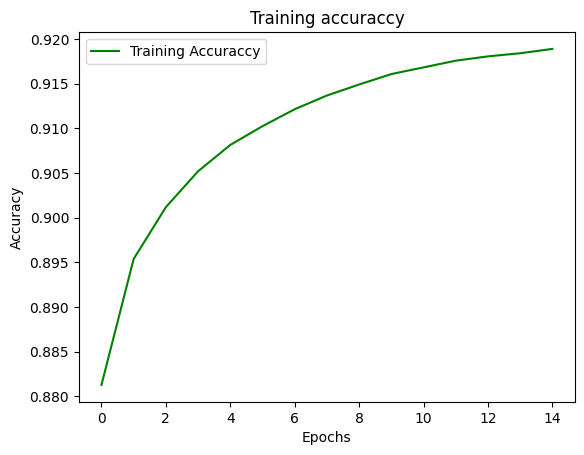

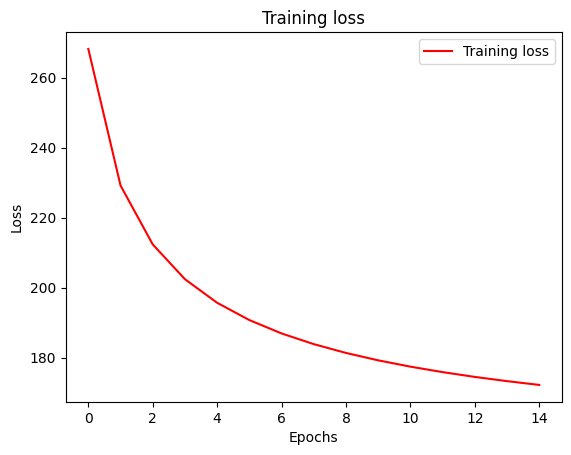

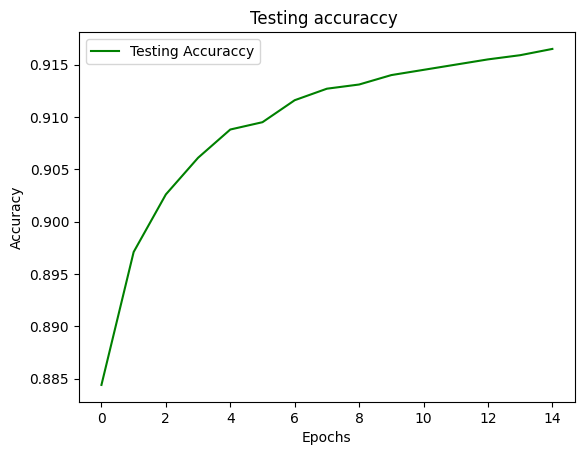

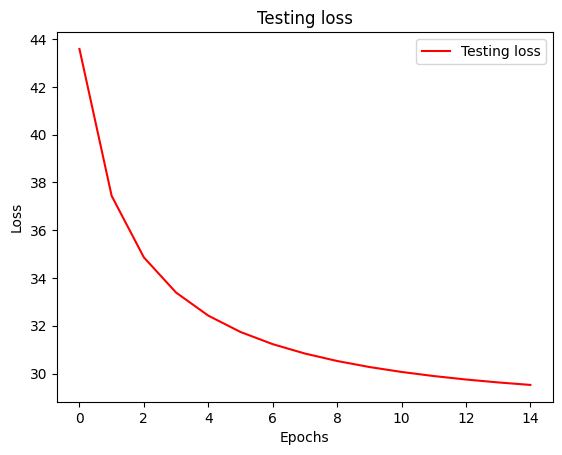

In [25]:
result_pca_rbf = LogisticRegression(train_X, test_X, train_y, test_y, lr=0.0025, batch_size=500, epoch=15)

In [26]:
best_train_acc = result_pca_rbf[0]
best_test_acc = result_pca_rbf[2]

best_train_acc = best_train_acc[np.argmax(best_train_acc)]
best_test_acc = best_test_acc[np.argmax(best_test_acc)]

best_train_acc, best_test_acc


(0.9188833333333334, 0.9165)

# LDA

In [27]:
seq = np.random.randint(0,60000,20000)
train_sampled_X = original_train_X[seq]
train_sampled_y = original_train_y[seq]
test_y = original_test_y
train_y = train_sampled_y

# Normalize Data:
sc = StandardScaler()

# First fit then transform
train_sampled_X = sc.fit_transform(train_sampled_X)
original_test_X = sc.transform(original_test_X)

train_X,test_X = dim_reduction('lda','rbf',train_sampled_X,original_test_X,train_sampled_y)


  7%|▋         | 1/15 [00:00<00:10,  1.28it/s]

-- Train:  0 : Accuraccy =  0.71525 	Error:  270.47898345836785  --
-- Test:  0 : Accuraccy =  0.7022 	Error:  137.85330555341676  --


 13%|█▎        | 2/15 [00:01<00:10,  1.27it/s]

-- Train:  1 : Accuraccy =  0.8489 	Error:  175.6155532900662  --
-- Test:  1 : Accuraccy =  0.8292 	Error:  92.21346782230707  --


 20%|██        | 3/15 [00:02<00:09,  1.26it/s]

-- Train:  2 : Accuraccy =  0.86475 	Error:  139.26127447985442  --
-- Test:  2 : Accuraccy =  0.8476 	Error:  75.03319334817533  --


 27%|██▋       | 4/15 [00:03<00:08,  1.27it/s]

-- Train:  3 : Accuraccy =  0.8719 	Error:  121.14043690027125  --
-- Test:  3 : Accuraccy =  0.8553 	Error:  66.5846657510757  --


 33%|███▎      | 5/15 [00:03<00:07,  1.27it/s]

-- Train:  4 : Accuraccy =  0.876 	Error:  110.4208258555233  --
-- Test:  4 : Accuraccy =  0.8591 	Error:  61.65175485457695  --


 40%|████      | 6/15 [00:04<00:07,  1.27it/s]

-- Train:  5 : Accuraccy =  0.8787 	Error:  103.3466351739482  --
-- Test:  5 : Accuraccy =  0.8621 	Error:  58.43939028627651  --


 47%|████▋     | 7/15 [00:05<00:06,  1.27it/s]

-- Train:  6 : Accuraccy =  0.87995 	Error:  98.32564802412108  --
-- Test:  6 : Accuraccy =  0.864 	Error:  56.190134320688585  --


 53%|█████▎    | 8/15 [00:06<00:05,  1.27it/s]

-- Train:  7 : Accuraccy =  0.8812 	Error:  94.57486922601647  --
-- Test:  7 : Accuraccy =  0.8648 	Error:  54.532998049157875  --


 60%|██████    | 9/15 [00:07<00:04,  1.27it/s]

-- Train:  8 : Accuraccy =  0.88295 	Error:  91.66517373237157  --
-- Test:  8 : Accuraccy =  0.8663 	Error:  53.26544111422299  --


 67%|██████▋   | 10/15 [00:07<00:03,  1.26it/s]

-- Train:  9 : Accuraccy =  0.88375 	Error:  89.34164674737791  --
-- Test:  9 : Accuraccy =  0.8672 	Error:  52.267613056847715  --


 73%|███████▎  | 11/15 [00:08<00:03,  1.26it/s]

-- Train:  10 : Accuraccy =  0.88495 	Error:  87.44322445260418  --
-- Test:  10 : Accuraccy =  0.8675 	Error:  51.46408829912951  --


 80%|████████  | 12/15 [00:09<00:02,  1.26it/s]

-- Train:  11 : Accuraccy =  0.8856 	Error:  85.86307266951202  --
-- Test:  11 : Accuraccy =  0.8676 	Error:  50.805041050812264  --


 87%|████████▋ | 13/15 [00:10<00:01,  1.26it/s]

-- Train:  12 : Accuraccy =  0.8864 	Error:  84.52749198012647  --
-- Test:  12 : Accuraccy =  0.8683 	Error:  50.25624368219341  --


 93%|█████████▎| 14/15 [00:11<00:00,  1.25it/s]

-- Train:  13 : Accuraccy =  0.88735 	Error:  83.38397044377415  --
-- Test:  13 : Accuraccy =  0.8684 	Error:  49.79341400523063  --


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]

-- Train:  14 : Accuraccy =  0.88785 	Error:  82.3940650144912  --
-- Test:  14 : Accuraccy =  0.8687 	Error:  49.39885429923788  --


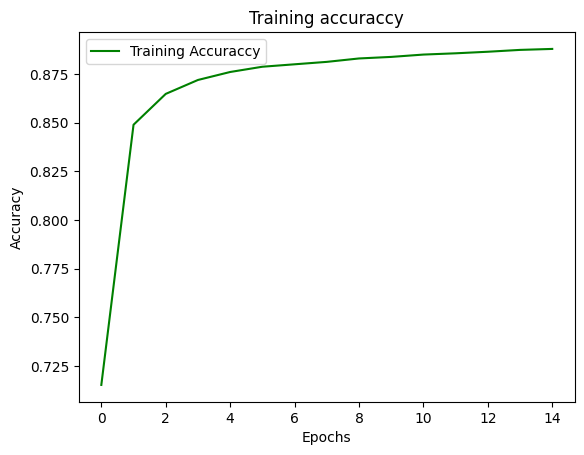

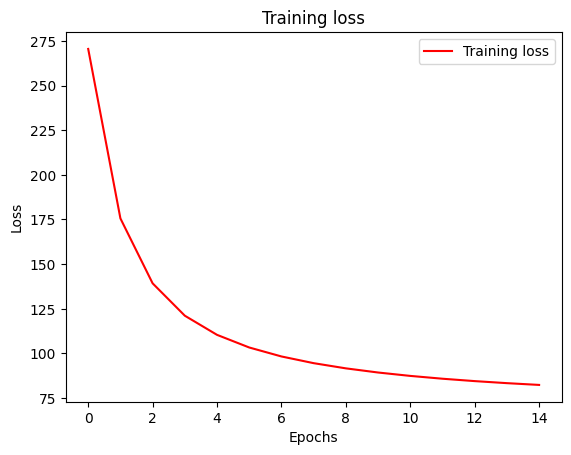

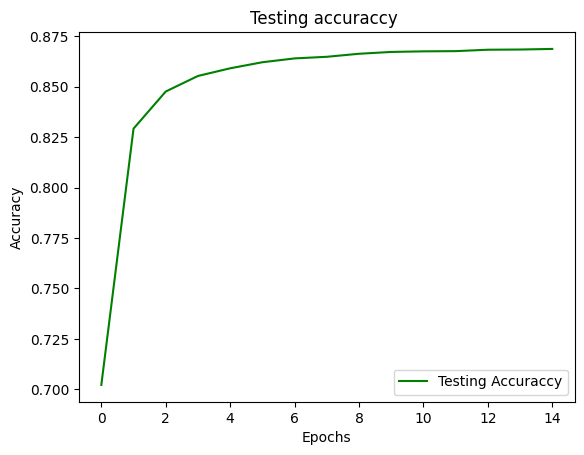

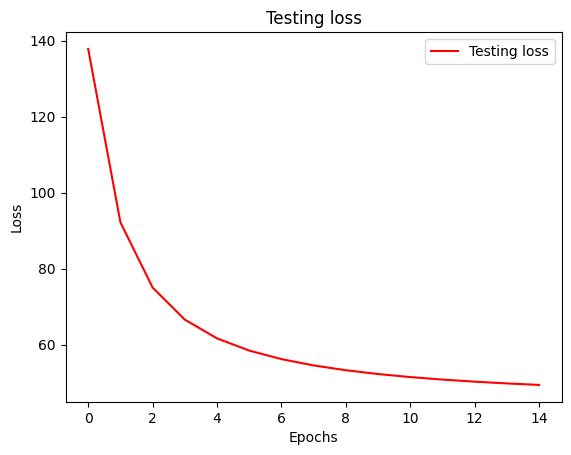

In [28]:
result_lda_rbf = LogisticRegression(train_X, test_X, train_y, test_y, lr=0.0025, batch_size=500, epoch=15)

In [29]:
best_train_acc = result_lda_rbf[0]
best_test_acc = result_lda_rbf[2]

best_train_acc = best_train_acc[np.argmax(best_train_acc)]
best_test_acc = best_test_acc[np.argmax(best_test_acc)]

best_train_acc, best_test_acc


(0.88785, 0.8687)